In [1]:
import os

import cv2
import numpy as np
import skimage.io as io
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

from vedaseg.runners import InferenceRunner
from vedaseg.datasets import build_dataset
from vedaseg.transforms import build_transform
from pycocotools.coco import COCO

In [2]:
%ls /DATA/home/tianhewang/work_spaces/project_x-ray/xray_seg_ks0_lr003_150E_1153/

20201015_203623.log  epoch_120.pth  epoch_15.pth  epoch_50.pth  epoch_80.pth
best_mIoU.pth        epoch_125.pth  epoch_20.pth  epoch_55.pth  epoch_85.pth
epoch_100.pth        epoch_130.pth  epoch_25.pth  epoch_5.pth   epoch_90.pth
epoch_105.pth        epoch_135.pth  epoch_30.pth  epoch_60.pth  epoch_95.pth
epoch_10.pth         epoch_140.pth  epoch_35.pth  epoch_65.pth
epoch_110.pth        epoch_145.pth  epoch_40.pth  epoch_70.pth
epoch_115.pth        epoch_150.pth  epoch_45.pth  epoch_75.pth


In [2]:
%env CUDA_VISIBLE_DEVICES=9

env: CUDA_VISIBLE_DEVICES=9


In [2]:
# checkpoint = '/DATA/home/tianhewang/work_spaces/project_x-ray/xray_seg_ks0_lr004_150E/best_mIoU.pth'
# checkpoint = '/DATA/home/tianhewang/work_spaces/project_x-ray/overfit_1153/best_mIoU.pth'
# checkpoint = '/DATA/home/tianhewang/work_spaces/project_x-ray/xray_cls_ks0_150E_1153/best_first_run.pth'
checkpoint = '/DATA/home/tianhewang/work_spaces/project_x-ray/cls_1345_averagepool_db/best_accuracy.pth'

nclasses = 2
ignore_label = 255
image_pad_value = (255, 255, 255)
size_h = 1153
size_w = 1345
dataset_type = 'XrayDataset'
dataset_root = ''
norm_cfg = dict(type='BN')
multi_label = True

img_norm_cfg = dict(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0)
inference_cfg = dict(
    gpu_id='9',
    multi_label=multi_label,
    transforms=[
        dict(type='LongestMaxSize',
             h_max=size_h,
             w_max=size_w,
             interpolation=cv2.INTER_LINEAR),
        dict(type='PadIfNeeded',
             min_height=size_h,
             min_width=size_w,
             value=image_pad_value,
             mask_value=ignore_label),
        dict(type='Normalize', **img_norm_cfg),
        dict(type='ToTensor'),
    ],
    model=dict(
        # model/encoder
        encoder=dict(
            backbone=dict(
                type='ResNet',
                arch='resnet50',
                replace_stride_with_dilation=[False, False, True],
                multi_grid=[1, 2, 4],
                norm_cfg=norm_cfg,
            ),
            enhance=dict(
                type='ASPP',
                from_layer='c5',
                to_layer='enhance',
                in_channels=2048,
                out_channels=256,
                atrous_rates=[6, 12, 18],
                mode='bilinear',
                align_corners=True,
                norm_cfg=norm_cfg,
                dropout=0.1,
            ),
        ),
        # model/decoder
        decoder=dict(
            type='GFPN',
            # model/decoder/blocks
            neck=[
                # model/decoder/blocks/block1
                dict(
                    type='JunctionBlock',
                    fusion_method='concat',
                    top_down=dict(
                        from_layer='enhance',
                        upsample=dict(
                            type='Upsample',
                            scale_factor=4,
                            scale_bias=-3,
                            mode='bilinear',
                            align_corners=True,
                        ),
                    ),
                    lateral=dict(
                        from_layer='c2',
                        type='ConvModule',
                        in_channels=256,
                        out_channels=48,
                        kernel_size=1,
                        norm_cfg=norm_cfg,
                        act_cfg=dict(type='Relu', inplace=True),
                    ),
                    post=None,
                    to_layer='p5',
                ),  # 4
            ],
        ),
        # model/head
        head=dict(
            type='Head',
            in_channels=304,
            inter_channels=256,
            out_channels=nclasses,
            norm_cfg=norm_cfg,
            num_convs=2,
            global_pool_cfg=dict(
                type='AdaptiveAvgPool2d',
                output_size=(1, 1),
            ),
#             norm_cfg=norm_cfg,
#             num_convs=2,
#             upsample=dict(
#                 type='Upsample',
#                 size=(size_h, size_w),
#                 mode='bilinear',
#                 align_corners=True,
#             ),
        )))
common_cfg = dict(seed=0,
              logger=dict(handlers=(
                  dict(type='StreamHandler', level='INFO'),
                  dict(type='FileHandler', level='INFO'),
              ), ),
              cudnn_deterministic=False,
              cudnn_benchmark=True,
              metrics=[
                  dict(type='MultiLabelIoU', num_classes=nclasses),
                  dict(type='MultiLabelMIoU', num_classes=nclasses),
              ],
              dist_params=dict(backend='nccl'))
transform_cfg = [
                dict(type='LongestMaxSize', h_max=size_h, w_max=size_w,
                     interpolation=cv2.INTER_LINEAR),
                dict(type='PadIfNeeded', min_height=size_h, min_width=size_w,
                     value=image_pad_value, mask_value=0),
#                 dict(type='FactorScale', scale=1/16,
#                      interpolation=cv2.INTER_LINEAR,
#                      always_apply=True,
#                      p=1.0),
                # dict(type='GaussianBlur', blur_limit=7, p=0.5),
                dict(type='Normalize', **img_norm_cfg),
                dict(type='ToTensor'),
            ]
dataset_cfg=dict(
    type=dataset_type,
    root=dataset_root,
    ann_file='/DATA/home/tianhewang/DataSets/'
                         'KS_X-ray/ks_0/ks_0_train.json',
    img_prefix='',
    multi_label=multi_label)

transform = build_transform(transform_cfg)
dataset = build_dataset(dataset_cfg, dict(transform=transform))

runner = InferenceRunner(inference_cfg, common_cfg)
runner.load_checkpoint(checkpoint)


2020-10-26 19:25:27,527 - INFO - Set cudnn deterministic False
2020-10-26 19:25:27,528 - INFO - Set cudnn benchmark True
2020-10-26 19:25:27,529 - INFO - Build model
2020-10-26 19:25:28,012 - INFO - ResNet init weights from pretreain
2020-10-26 19:25:28,549 - INFO - ASPP init weights
2020-10-26 19:25:28,731 - INFO - GFPN init weights
2020-10-26 19:25:28,740 - INFO - Head siwtched to classification mode
2020-10-26 19:25:28,741 - INFO - Head init weights
2020-10-26 19:25:35,455 - INFO - Load checkpoint from /DATA/home/tianhewang/work_spaces/project_x-ray/cls_1345_averagepool_db/best_accuracy.pth


{'meta': {'best': OrderedDict([('accuracy', 0.8860294117647058)]),
  'epoch': 113,
  'iter': 92660,
  'lr': array([0.01134905]),
  'time': 'Thu Oct 22 22:51:29 2020'},
 'state_dict': OrderedDict([('0.0.conv1.weight',
               tensor([[[[ 4.2463e-03,  6.9698e-02,  6.7331e-02,  ...,  9.1299e-02,
                           9.1133e-02,  8.8854e-02],
                         [-2.2614e-02,  4.3217e-02,  4.5056e-02,  ...,  7.0432e-02,
                           6.8208e-02,  6.5823e-02],
                         [-2.6977e-02,  3.8813e-02,  3.9689e-02,  ...,  7.5837e-02,
                           7.2731e-02,  7.1248e-02],
                         ...,
                         [-3.3580e-02,  3.4697e-02,  3.1735e-02,  ...,  4.8538e-02,
                           5.3362e-02,  6.0612e-02],
                         [-3.3327e-02,  3.5978e-02,  3.6854e-02,  ...,  5.9924e-02,
                           5.5093e-02,  5.6192e-02],
                         [-4.1750e-02,  2.7086e-02,  2.7109e-02,  ..

In [8]:
import torch
torch.cuda.empty_cache()

In [3]:
anno_file = '/DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_val.json'
# anno_file = '/DATA/home/tianhewang/DataSets/KS_X-ray/ks_overfit/ks_overfit.json'
ana_coco = COCO(anno_file)
keys = list(ana_coco.imgs.keys())


def get_label(mask):
    mask_ = mask.astype(int)
    res = [0, 0]
    for l in range(2):
        mask_l = mask_[..., l].reshape(-1)
#         print(f"max of clas{l} -> {max(mask_l)}")
        if 1 in mask_l:
            res[l] = 1
#     mask1 = mask_[0, ...].reshape(-1)
#     mask2 = mask_[1, ...].reshape(-1)
    return res

def get_label_score(mask):
    res = [0, 0]
    for l in range(2):
        mask_l = mask[..., l].reshape(-1)
#         print(f"max of clas{l} -> {max(mask_l)}")
        max_val = max(mask_l)
        res[l] = max_val
#     mask1 = mask_[0, ...].reshape(-1)
#     mask2 = mask_[1, ...].reshape(-1)
    return res


def inverse_resize(pred, image_shape, interpo=cv2.INTER_NEAREST):
    pred = cv2.resize(pred, (image_shape[1], image_shape[0]),
                      interpolation=interpo)
    return pred


def cal_resized_shape(pred, image_shape):
    h, w = image_shape
    size_h, size_w = pred.shape[0], pred.shape[1]
    scale_factor = min(size_h / h, size_w / w)
    resized_h, resized_w = int(h * scale_factor), int(w * scale_factor)
    return resized_h, resized_w


def inverse_pad(pred, image_shape):
    h, w = image_shape
    return pred[:h, :w]

runner.getmap = True

score_list = []
label_list = []
for idxx in range(32):
    fn = ana_coco.imgs[keys[idxx]]['file_name']

    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, c = image.shape
    dummy_mask = np.zeros((h, w))
#     print(image.shape)
    output = runner(image, [dummy_mask])
#     print(output.shape)
    output = output.transpose((1, 2, 0))
#     print(output.shape)
    resized_shape = cal_resized_shape(output, image.shape[:2])
    output = inverse_pad(output, resized_shape)
    output = inverse_resize(output, image.shape[:2], interpo=cv2.INTER_LINEAR)

    img = ana_coco.loadImgs([keys[idxx]])[0]
    I = io.imread(img['file_name'])
#     plt.figure(figsize=(10, 5))
#     plt.imshow(I)
#     plt.axis('off')
    annIds = ana_coco.getAnnIds(imgIds=[img['id']], iscrowd=None)
#     print(annIds)
    anns = ana_coco.loadAnns(annIds)
    gt_label = [0, 0]
    for ann in anns:
        gt_label[ann['category_id'] - 1] = 1
#     print(output.shape)

    label_list.append(np.array(gt_label))
    score_list.append(np.array(get_label_score(output)))
    
#     print(gt_label)
#     print(get_label_score(output))
#     ana_coco.showAnns(anns, draw_bbox=False)

#     result(fn, 
#            output, 
#            multi_label=multi_label,
#            classes=('kn', 'sc'), 
#            palette=[(0, 0, 255), (0, 255, 0)], 
#            show=True,
#            out=None)

2020-10-26 18:04:08,925 - ERROR - Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/DATA/home/tianhewang/anaconda3/envs/wider/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-4a1fa14f957b>", line 63, in <module>
    output = output.transpose((1, 2, 0))
ValueError: axes don't match array

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/DATA/home/tianhewang/anaconda3/envs/wider/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/DATA/home/tianhewang/anaconda3/envs

TypeError: object of type 'NoneType' has no len()

In [3]:
anno_file = '/DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_val.json'
# anno_file = '/DATA/home/tianhewang/DataSets/KS_X-ray/ks_overfit/ks_overfit.json'
ana_coco = COCO(anno_file)
keys = list(ana_coco.imgs.keys())


def get_label(mask):
    mask_ = mask.astype(int)
    res = [0, 0]
    for l in range(2):
        mask_l = mask_[..., l].reshape(-1)
#         print(f"max of clas{l} -> {max(mask_l)}")
        if 1 in mask_l:
            res[l] = 1
#     mask1 = mask_[0, ...].reshape(-1)
#     mask2 = mask_[1, ...].reshape(-1)
    return res

def get_label_score(mask):
    res = [0, 0]
    for l in range(2):
        mask_l = mask[..., l].reshape(-1)
#         print(f"max of clas{l} -> {max(mask_l)}")
        max_val = max(mask_l)
        res[l] = max_val
#     mask1 = mask_[0, ...].reshape(-1)
#     mask2 = mask_[1, ...].reshape(-1)
    return res


def inverse_resize(pred, image_shape, interpo=cv2.INTER_NEAREST):
    pred = cv2.resize(pred, (image_shape[1], image_shape[0]),
                      interpolation=interpo)
    return pred


def cal_resized_shape(pred, image_shape):
    h, w = image_shape
    size_h, size_w = pred.shape[0], pred.shape[1]
    scale_factor = min(size_h / h, size_w / w)
    resized_h, resized_w = int(h * scale_factor), int(w * scale_factor)
    return resized_h, resized_w


def inverse_pad(pred, image_shape):
    h, w = image_shape
    return pred[:h, :w]

runner.getmap = True

score_list = []
label_list = []

for idx, (img_id, img_info) in enumerate(
    tqdm(ana_coco.imgs.items(),
         dynamic_ncols=True,
         unit='images',
         unit_scale=True)):

    image = cv2.imread(img_info['file_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, c = image.shape
    dummy_mask = np.zeros((h, w))
    
    output = runner(image, [dummy_mask])
#     print(output)
#     assert 1 == 0

#     output = output.transpose((1, 2, 0))
#     resized_shape = cal_resized_shape(output, image.shape[:2])
#     output = inverse_pad(output, resized_shape)
#     output = inverse_resize(output, image.shape[:2], interpo=cv2.INTER_LINEAR)

    annIds = ana_coco.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = ana_coco.loadAnns(annIds)
    
    gt_label = [0, 0]
    for ann in anns:
        gt_label[ann['category_id'] - 1] = 1

    label_list.append(np.array(gt_label))
#     score_list.append(np.array(get_label_score(output)))
    score_list.append(np.array(output))
    
label_list = np.vstack(label_list)
score_list = np.vstack(score_list)
result_list = np.where(score_list >= 0.5, 1, 0)

acc = metrics.accuracy_score(label_list, result_list)
AP = metrics.average_precision_score(label_list, score_list, average=None)
mAP = metrics.average_precision_score(label_list, score_list)
recall = metrics.recall_score(label_list, result_list, average=None)
precision = metrics.precision_score(label_list, result_list, average=None)
print(anno_file)
print(f"acc:{acc}\nAP:{AP}\nmAP:{mAP}\nrecall:{recall, sum(recall)/2}\nprecision:{precision, sum(precision)/2}")


#####################################################################################
#600

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_test.json
# acc:0.7761557177615572
# AP:[0.98899341 0.96975976]
# mAP:0.97937658525215
# recall:(array([0.98305085, 0.95854922]), 0.9708000351277772)
# precision:(array([0.86309524, 0.82589286]), 0.8444940476190477)

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_val.json
# acc:0.8268292682926829
# AP:[0.99159151 0.97487032]
# mAP:0.9832309169598921
# recall:(array([0.99339934, 0.95480226]), 0.9741007999104996)
# precision:(array([0.90936556, 0.82843137]), 0.8688984657307032)

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_train.json
# acc:0.8398902104300091
# AP:[0.99538636 0.99189055]
# mAP:0.9936384577551061
# recall:(array([0.99780509, 0.98356511]), 0.9906850998225205)
# precision:(array([0.88203337, 0.88610478]), 0.884069077868617)

#####################################################################################
#1345

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_test.json
# acc:0.8467153284671532
# AP:[0.99156364 0.96957777]
# mAP:0.98057070423336
# recall:(array([0.9559322 , 0.89119171]), 0.9235619566171951)
# precision:(array([0.92156863, 0.90526316]), 0.9134158926728586)
# roc_auc_score:[0.87451783 0.90431145]

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_val.json
# acc:0.8804878048780488
# AP:[0.99209056 0.96635564]
# mAP:0.9792231038956735
# recall:(array([0.97029703, 0.86440678]), 0.9173519046819936)
# precision:(array([0.96078431, 0.92727273]), 0.9440285204991088)
# roc_auc_score:[0.92907375 0.90645232]

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_train.json
# acc:0.9939005794449527
# AP:[0.99999788 0.9996641 ]
# mAP:0.9998309885976415
# recall:(array([1.      , 0.994311]), 0.9971554993678888)
# precision:(array([0.99737303, 0.99620013]), 0.9967865782173869)
# roc_auc_score:[0.997003   0.99538767]

####################################################################################
# cls

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_test.json
# acc:0.6545012165450121
# AP:[0.95182571 0.78883643]
# mAP:0.8703310745188886
# recall:(array([0.90169492, 0.88601036]), 0.8938526389742689)
# precision:(array([0.86084142, 0.69795918]), 0.7794003038108448)
# roc_auc_score:[0.76550263 0.77328041]

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_val.json
# acc:0.6487804878048781
# AP:[0.95761486 0.84293378]
# mAP:0.9002743221505636
# recall:(array([0.89108911, 0.88700565]), 0.8890473793142026)
# precision:(array([0.8852459 , 0.66525424]), 0.7752500694637399)
# roc_auc_score:[0.78199315 0.77397493]

# /DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_train.json
# acc:0.6941140591643794
# AP:[0.95757545 0.88345141]
# mAP:0.9205134290449605
# recall:(array([0.92976295, 0.90265487]), 0.9162089086063695)
# precision:(array([0.86308068, 0.74336283]), 0.8032217582274921)
# roc_auc_score:[0.79704931 0.8060711 ]



100%|██████████| 410/410 [01:29<00:00, 4.56images/s] 

/DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_val.json
acc:0.8097560975609757
AP:[0.97527311 0.88094533]
mAP:0.9281092210964488
recall:(array([0.94719472, 0.90960452]), 0.9283996196229792)
precision:(array([0.91987179, 0.81313131]), 0.8665015540015539)


In [4]:
acc = metrics.accuracy_score(label_list, result_list)
AP = metrics.average_precision_score(label_list, score_list, average=None)
mAP = metrics.average_precision_score(label_list, score_list)
recall = metrics.recall_score(label_list, result_list, average=None)
precision = metrics.precision_score(label_list, result_list, average=None)
roc_auc_score = metrics.roc_auc_score(label_list, result_list, average=None)
print(anno_file)
print(f"acc:{acc}\nAP:{AP}\nmAP:{mAP}\nrecall:{recall, sum(recall)/2}\n"
      f"precision:{precision, sum(precision)/2}")
print(f"roc_auc_score:{roc_auc_score}")

/DATA/home/tianhewang/DataSets/KS_X-ray/ks_0/ks_0_val.json
acc:0.8097560975609757
AP:[0.97527311 0.88094533]
mAP:0.9281092210964488
recall:(array([0.94719472, 0.90960452]), 0.9283996196229792)
precision:(array([0.91987179, 0.81313131]), 0.8665015540015539)
roc_auc_score:[0.85677493 0.87540312]


In [27]:
precision, recall, thres = precision_recall_curve(label_list[:, 0], score_list[:, 0])

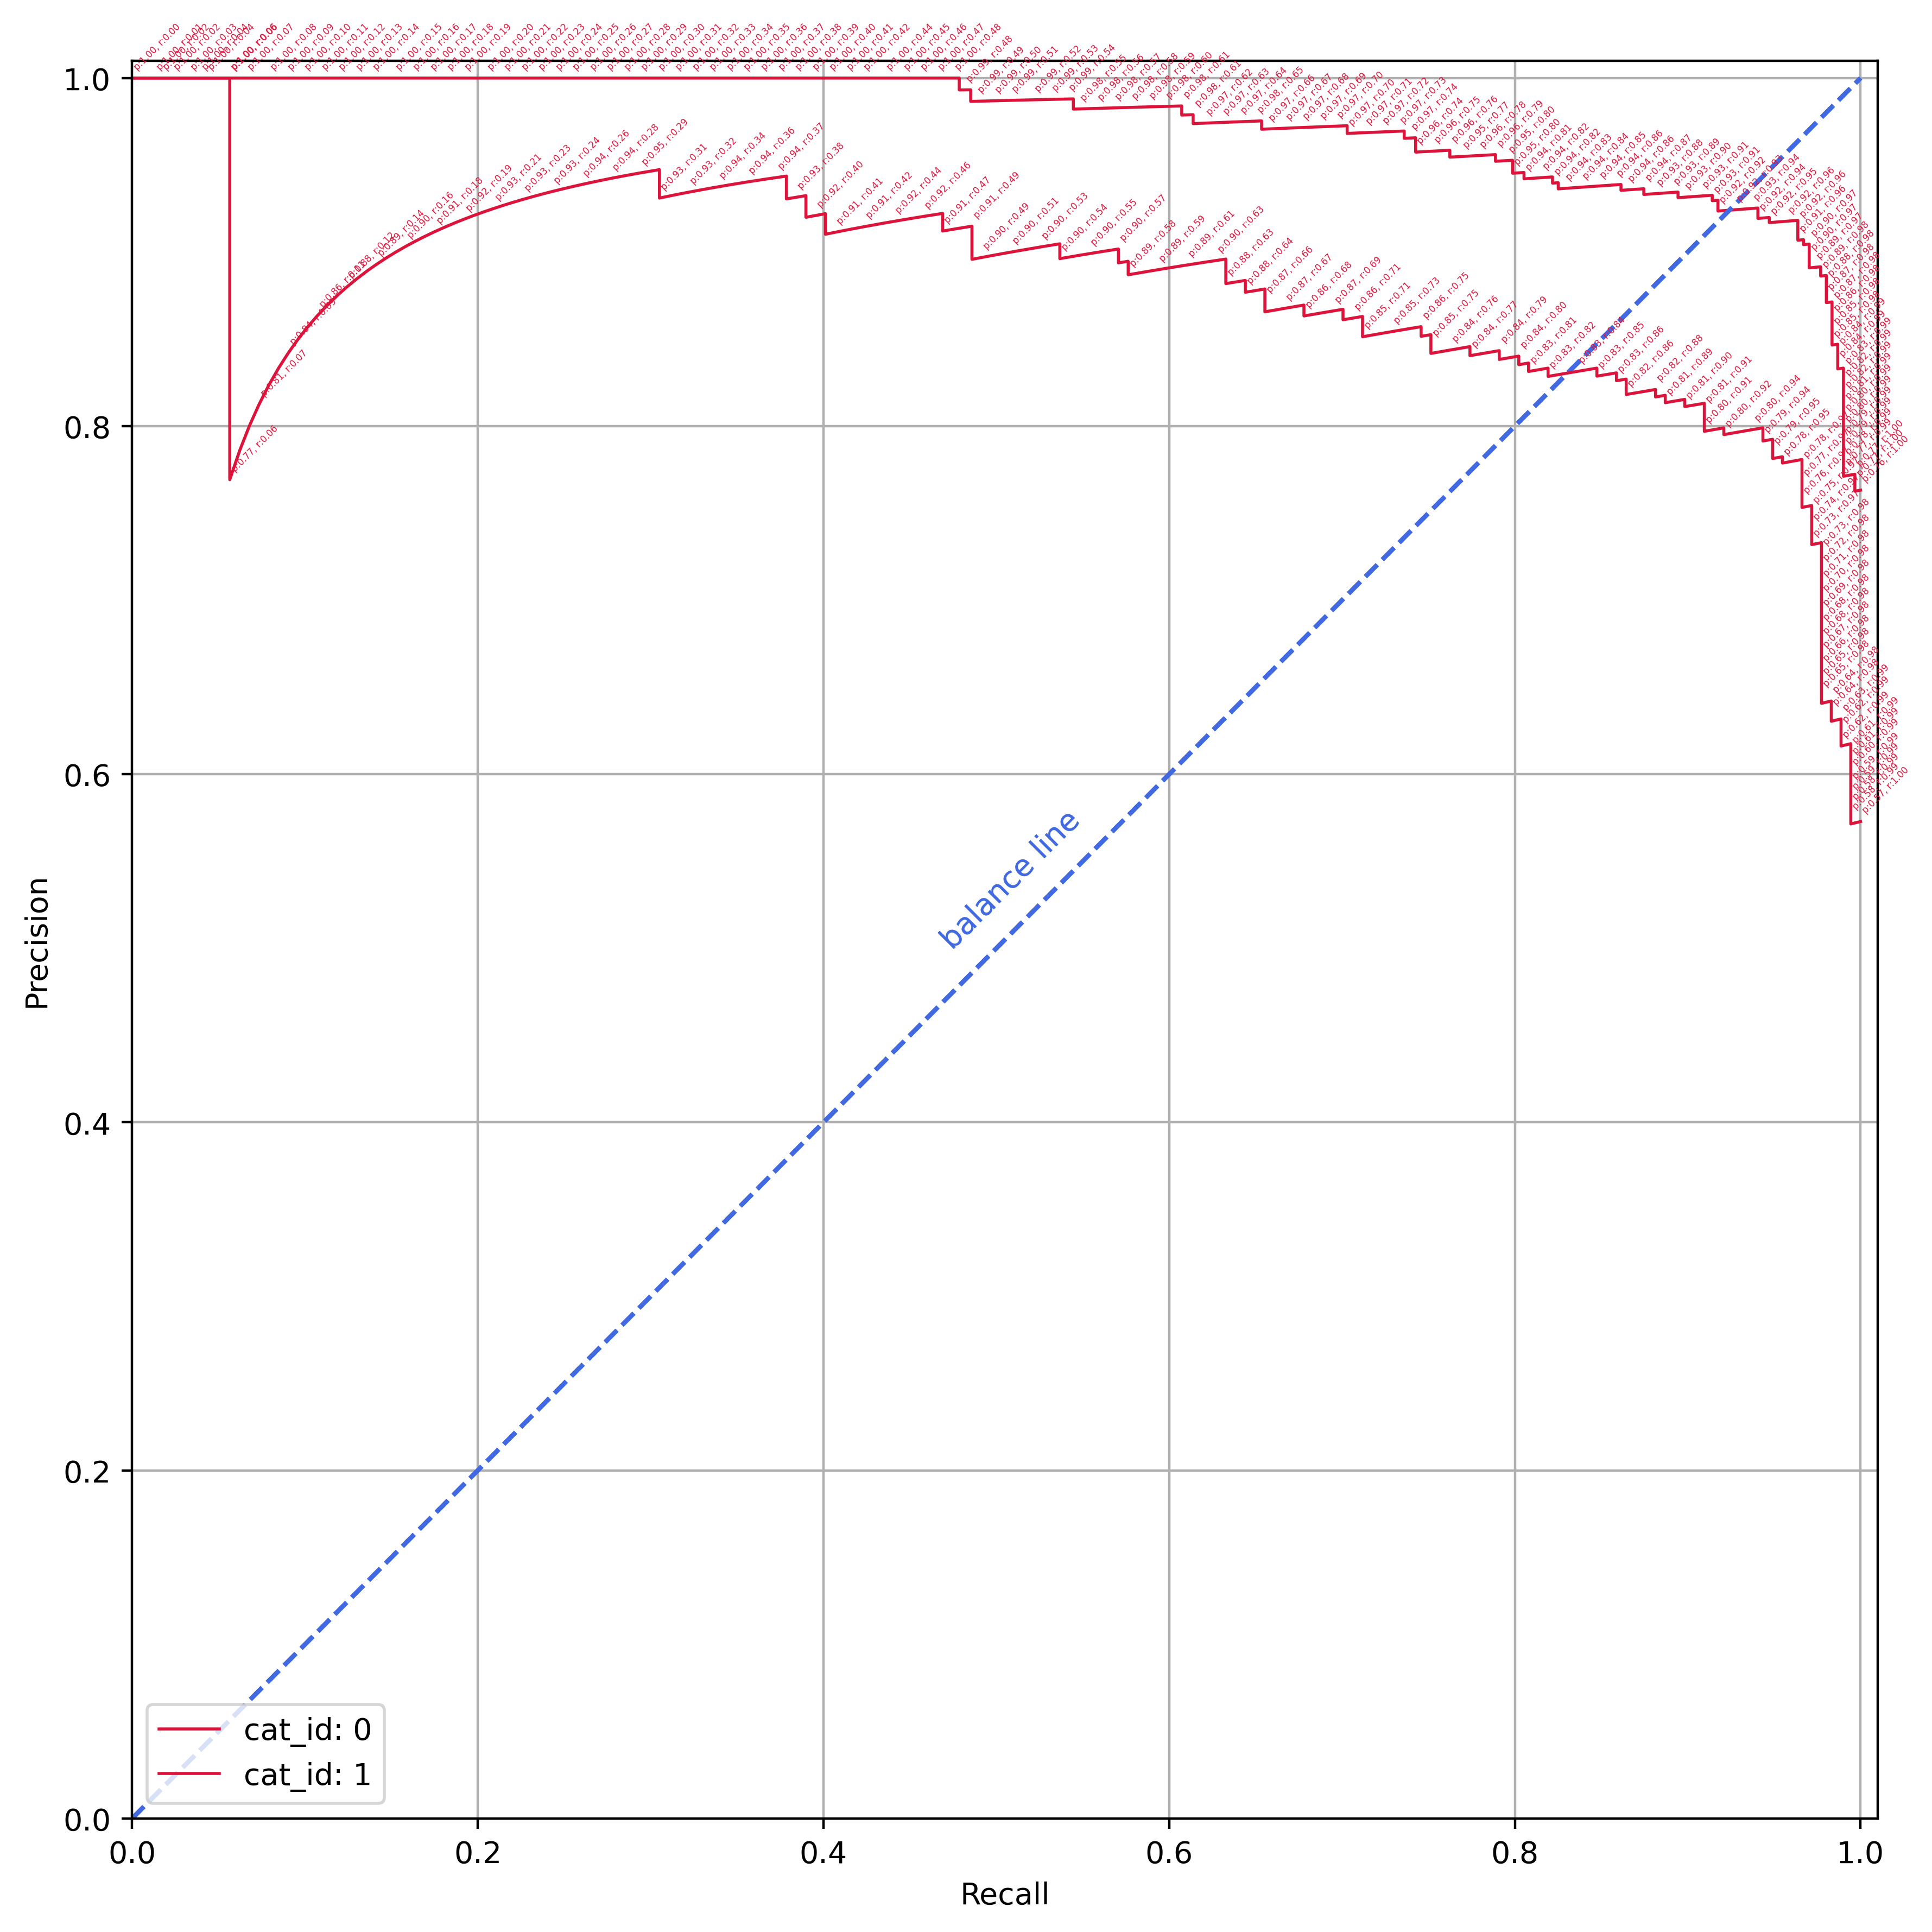

In [43]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(label_list[:, i],
                                                        score_list[:, i])
    average_precision[i] = average_precision_score(label_list[:, i], score_list[:, i])
    
    
    plt.figure(11, figsize=(9, 9), dpi=400)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.01])
    plt.xlim([0.0, 1.01])
    plt.grid(True)
    plt.plot(np.arange(0.0, 1.01, 0.01), 
             np.arange(0.0, 1.01, 0.01),
             color='royalblue', linestyle='--')
    plt.annotate("balance line", 
                 xy=(0.5, 0.5), 
                 color='royalblue',
                 rotation=45, 
                 xytext=(-20, 0), 
                 textcoords='offset points')

    line_kwargs = {
        'label': f'cat_id: {i}',
        'color': 'crimson',
        'linestyle': '-',
        'linewidth': 1,
    }

    plt.plot(recall[i],
             precision[i],
             **line_kwargs)
#     print(len(precision))

    for idx, (prec, recal) in enumerate(zip(precision[i], recall[i])):
        if idx % 3:
            continue
        text = f"p:{prec:.2f}, r:{recal:.2f}"
        plt.annotate(text, xy=(recal, prec),
                     xytext=(recal, prec + 0.005),
                     color=line_kwargs['color'], fontsize=3, rotation=45)
        
    
#     for j, x in enumerate(np.arange(0.8, 1.01, 0.01)):
#         text = [round(x, 3),
#                 round(precision[i][j], 3),
#                 round(recall[i][j], 3)]
#         plt.annotate(text, xy=(x, precision[i][j]),
#                      xytext=(x, precision[i][j] + 0.005),
#                      color=line_kwargs['color'], fontsize=3, rotation=80)

    plt.legend(loc='lower left')
    plt.tight_layout()
plt.show()
#     plt.savefig(os.path.join(export_path, timestamp + f'_pr_curve_of_cat_{cat_id}'), dpi=400)
#     plt.close()
    
    
    
    

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(label_list[:, i],
                                                        score_list[:, i])
    average_precision[i] = average_precision_score(label_list[:, i], score_list[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(label_list.ravel(),
    score_list.ravel())
average_precision["micro"] = average_precision_score(label_list, score_list,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.94


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.94')

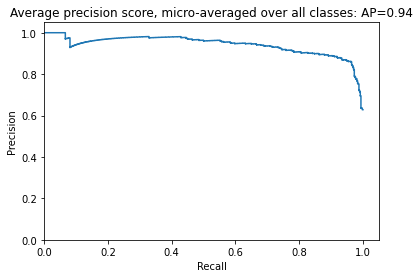

In [8]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

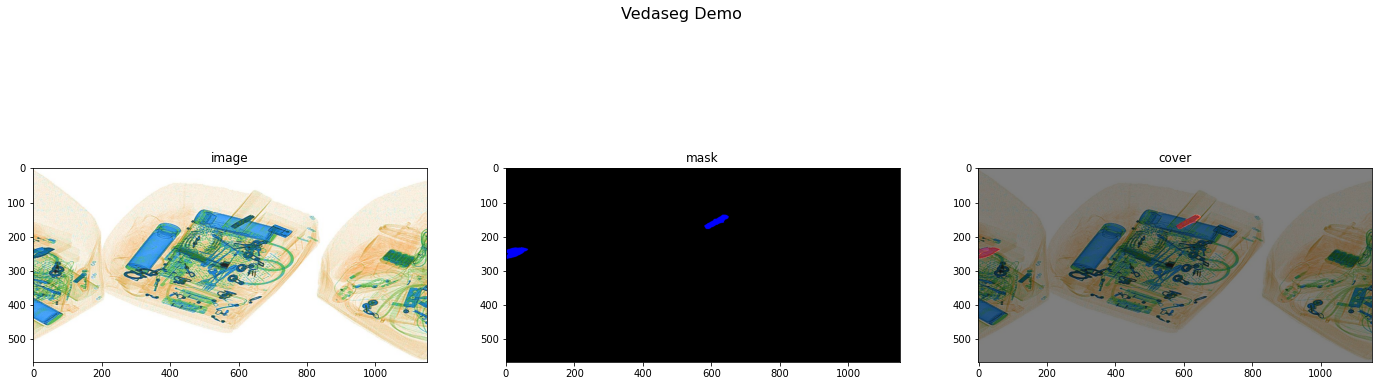

In [5]:
result(fn, 
       output, 
       multi_label=multi_label,
       classes=('kn', 'sc'), 
       palette=[(0, 0, 255), (0, 255, 0)], 
       show=True,
       out=None)

In [1]:
img = ana_coco.loadImgs([keys[idxx]])[0]

I = io.imread(img['file_name'])
plt.figure(figsize=(20,10))
plt.imshow(I)
plt.axis('off')
annIds = ana_coco.getAnnIds(imgIds=[img['id']], iscrowd=None)
# print(annIds)
anns = ana_coco.loadAnns(annIds)
ana_coco.showAnns(anns, draw_bbox=False)

NameError: name 'ana_coco' is not defined

In [10]:
print(output.shape)

def plot_result(img, mask, cover):
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle("Vedaseg Demo", y=0.95, fontsize=16)

    ax[0].set_title('image')
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    ax[1].set_title(f'mask')
    ax[1].imshow(mask)

    ax[2].set_title(f'cover')
    ax[2].imshow(cv2.cvtColor(cover, cv2.COLOR_BGR2RGB))
    plt.show()


def result(fname,
           pred_mask,
           classes,
           multi_label=False,
           palette=None,
           show=False,
           out=None):
    if palette is None:
        palette = np.random.randint(0, 255, size=(len(classes), 3))
    else:
        palette = np.array(palette)
    img_ori = cv2.imread(fname)
    mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(palette):
        if multi_label:
            mask[pred_mask[:, :, label] == 1] = color
        else:
            mask[pred_mask == label, :] = color
            
        img_ori = cv2.resize(img_ori, 
                             (pred_mask.shape[1], pred_mask.shape[0]),
                             interpolation=cv2.INTER_NEAREST)

    cover = img_ori * 0.5 + mask * 0.5
    cover = cover.astype(np.uint8)

    if out is not None:
        _, fullname = os.path.split(fname)
        fname, _ = os.path.splitext(fullname)
        save_dir = os.path.join(out, fname)
        os.makedirs(save_dir, exist_ok=True)
        cv2.imwrite(os.path.join(save_dir, 'img.png'), img_ori)
        cv2.imwrite(os.path.join(save_dir, 'mask.png'), mask)
        cv2.imwrite(os.path.join(save_dir, 'cover.png'), cover)
        if multi_label:
            for i in range(pred_mask.shape[-1]):
                cv2.imwrite(os.path.join(save_dir, classes[i] + '.png'),
                            pred_mask[:, :, i] * 255)

    if show:
        plot_result(img_ori, mask, cover)



(594, 918, 2)


In [ ]:
    def validate(self, dataloader, thresh=0.5):
        score_list = []
        label_list = []
        result_list = []
        with torch.no_grad():
            self.model.eval()
            for cnt, (img, label) in enumerate(dataloader):
                print('validate:{}/{} {}\r'.format(cnt, len(dataloader), img.shape), end='')
                img = img.cuda()
                result, score = self.infer(img)
                score_list.append(score)
                label = label.cpu().detach().numpy()
                result_list.append(result)
                label_list.append(label)

            result_list = np.vstack(result_list)
            label_list = np.vstack(label_list)
            score_list = np.vstack(score_list)
            acc = metrics.accuracy_score(label_list, result_list)
            AP = metrics.average_precision_score(label_list, score_list, average=None)
            mAP = metrics.average_precision_score(label_list, score_list)
            recall = metrics.precision_score(label_list, result_list, average=None)
            out_put1 = 'eval acc:{}, mAP:{}\n'.format(acc, mAP)
            out_put2 = 'AP:{}\n recall:{}\n'.format(AP, recall)
            print(out_put1)
            print(out_put2)
        return {'acc':acc, 'AP':AP, 'mAP':mAP, 'recall':recall}

In [62]:
a = np.zeros((16, 16))
a[6:8, 6:8] = 1
print(a)
b = cv2.resize(a, (2, 2), interpolation=cv2.INTER_LINEAR)
print(b)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0.]
 [0. 0.]]


In [92]:
a = np.zeros((2,2))
a[0, 0] = 0.9
a[1, 1] = 0.8
a[1, 0] = 0.8
a[0, 1] = 0.9

# a[0, 0] = 1
# a[1, 1] = 1
# a[2, 0] = 1
# a[0, 2] = 1

a16 = cv2.resize(a, (16, 16), interpolation=cv2.INTER_LINEAR)

with np.printoptions(precision=1, suppress=True):
    print(a)
    print()
    print(a16)

[[0.9 0.9]
 [0.8 0.8]]

[[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 